<a href="https://colab.research.google.com/github/Lutris98/PersonalProject/blob/main/2.Analytics/21.1Q_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.투자개요

투자할 종목은 <br>
다다 넥서스(DADA)<br>
마이크로소프트(MSFT)<br>
화이자(PFE)<br>

#2.포트폴리오 구성

In [338]:
!pip install yfinance
!pip install mplfinance

In [339]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf 
yf.pdr_override()
df1=pdr.get_data_yahoo('DADA') #위에 4개 부분만 바꿔두면 됨
df2=pdr.get_data_yahoo('MSFT')
df3=pdr.get_data_yahoo('PFE')
stocks=['DADA','MSFT','PFE']
df=pd.concat([df1['Close'],df2['Close'],df3['Close']],axis=1)
df=df.iloc[-91:-1] 
df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Close,Close,Close
Date,,,
2020-10-09,29.690001,215.809998,34.905125
2020-10-12,33.400002,221.399994,34.933586
2020-10-13,34.049999,222.860001,35.009487
2020-10-14,32.750000,220.860001,34.971539
2020-10-15,33.709999,219.660004,34.677418
...,...,...,...
2021-02-11,44.930000,244.490005,34.430000
2021-02-12,44.560001,244.990005,34.720001
2021-02-16,45.180000,243.699997,34.689999


In [340]:
daily_ret=df.pct_change() 
daily_ret.iloc[0]=daily_ret.iloc[1]
daily_cov=daily_ret.cov() 
annual_ret=daily_ret.mean()*250
annual_cov=daily_cov*250 
port_ret=[] 
port_risk=[]
port_weights=[]
port_sharpe=[]

In [341]:
import numpy as np
for _ in range(20000):
  weights=np.random.random(3) 
  weights=weights/np.sum(weights) 
  returns=np.dot(weights,annual_ret) 
  risk=np.sqrt(np.dot(weights.T,np.dot(annual_cov,weights))) 
  sharpe=(returns-0.005)/risk 
  port_ret.append(returns)
  port_risk.append(risk)
  port_weights.append(weights)
  port_sharpe.append(sharpe)
portfolio={'Return':port_ret,'Risk':port_risk,'Sharpe':port_sharpe} 
for i,s in enumerate(stocks): 
  portfolio[s]=[weight[i] for weight in port_weights] 
port_df=pd.DataFrame(portfolio)

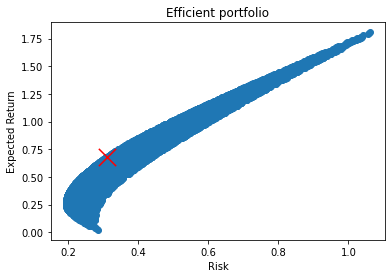

In [342]:
import matplotlib.pyplot as plt
plt.scatter(data=port_df,x='Risk',y='Return')
plt.title('Efficient portfolio')
plt.xlabel('Risk')
plt.ylabel('Expected Return')
max_sharpe=port_df.loc[port_df['Sharpe']==port_df['Sharpe'].max()] 
plt.scatter(x=max_sharpe['Risk'],y=max_sharpe['Return'],c='r',marker='x',s=300) 
plt.show()

In [343]:
max_sharpe

,Return,Risk,Sharpe,DADA,MSFT,PFE
81,0.682148,0.310746,2.179107,0.179243,0.805092,0.015665


#3.매수,매도 시점

##1)종목1

###• 볼린저 밴드

In [344]:
df=df1[['Open','High','Low','Close','Volume']]
df=df.iloc[-251:-1]
df['MA20']=df['Close'].rolling(window=20,min_periods=1).mean()
std=df['Close'].rolling(window=20,min_periods=1).std() 
std.fillna(method='bfill',inplace=True) 
df['Upper']=df['MA20']+2*std
df['Lower']=df['MA20']-2*std
df['%B']=100*(df.Close-df.Lower)/(df.Upper-df.Lower)
df['TP']=(df['High']+df['Lower']+df['Close'])/3 
df['PMF']=0
df['NMF']=0
df

,Open,High,Low,Close,Volume,MA20,Upper,Lower,%B,TP,PMF,NMF
Date,,,,,,,,,,,,
2020-06-05,18.299999,18.500000,15.240000,15.990000,7825900,15.990000,17.418356,14.561644,50.000000,16.350548,0,0
2020-06-08,17.080000,17.490000,16.250000,17.000000,2676100,16.495000,17.923356,15.066644,67.677670,16.518881,0,0
2020-06-09,17.299999,17.490000,15.700000,16.040001,1749100,16.343334,17.481812,15.204855,36.678153,16.244952,0,0
2020-06-10,16.150000,16.750000,14.800000,15.250000,3954000,16.070000,17.505084,14.634916,21.430242,15.544972,0,0
2020-06-11,14.750000,15.100000,14.670000,14.750000,1108000,15.806000,17.520211,14.091789,19.198659,14.647263,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-11,44.860001,46.950001,44.419998,44.930000,1350100,44.287500,47.166431,41.408568,61.158662,44.429523,0,0
2021-02-12,44.650002,45.270000,44.070000,44.560001,422700,44.433500,47.029361,41.837639,52.436599,43.889214,0,0
2021-02-16,45.779999,47.000000,44.560001,45.180000,1016800,44.542500,47.067014,42.017986,62.626198,44.732662,0,0


In [345]:
for i in range(len(df)-1): 
  if df.TP.values[i]<df.TP.values[i+1]: 
    df.PMF.values[i+1]=df.TP.values[i+1]*df.Volume.values[i+1] 
    df.NMF.values[i+1]=0
  elif df.TP.values[i]>df.TP.values[i+1]:
    df.NMF.values[i+1]=df.TP.values[i+1]*df.Volume.values[i+1] 
    df.PMF.values[i+1]=0
MF=df.PMF.rolling(window=10).sum()/df.NMF.rolling(window=10).sum()
df['MFI']=100-100/(1+MF)

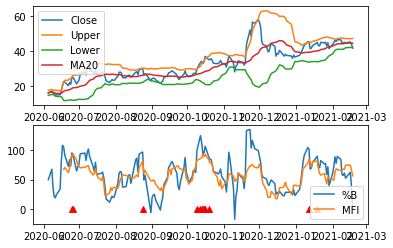

In [346]:
plt.subplot(2,1,1)
plt.plot(df.index,df.Close,label='Close')
plt.plot(df.index,df.Upper,label='Upper')
plt.plot(df.index,df.Lower,label='Lower')
plt.plot(df.index,df.MA20,label='MA20')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(df.index,df['%B'],label='%B')
plt.plot(df.index,df.MFI,label='MFI')
buy=[]
sell=[]
df.index=df.index.date 
for i in range(len(df)):
  if df['%B'].values[i]>80 and df.MFI.values[i]>80:
    plt.plot(df.index.values[i],0,'r^')
    buy.append(df.index.values[i])
  if df['%B'].values[i]<20 and df.MFI.values[i]<20:
    plt.plot(df.index.values[i],0,'bv')
    sell.append(df.index.values[i])
plt.legend(loc='best')

<BarContainer object of 178 artists>

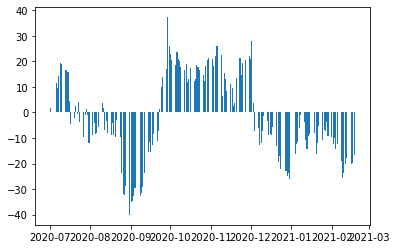

In [347]:
intensity=df.Volume*(2*df.Close-df.High-df.Low)/(df.High-df.Low) 
df['%I']=100*intensity.rolling(window=20).sum()/df.Volume.rolling(window=20).sum()
plt.bar(df.index,df['%I'],label='%I in 20days')

###• 삼중창

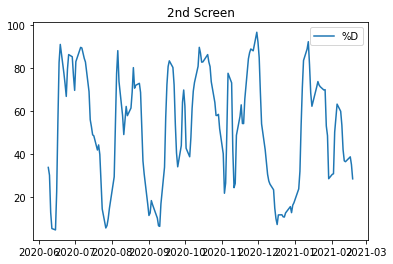

In [348]:
L14=df.Low.rolling(window=14,min_periods=1).min() 
H14=df.High.rolling(window=14,min_periods=1).max()
df['%K']=100*(df['Close']-L14)/(H14-L14)
df['%D']=df['%K'].rolling(window=3).mean() 
plt.plot(df.index,df['%D'],label='%D')
plt.title('2nd Screen')
plt.legend(loc='best')

Text(0.5, 1.0, '3rd Screen')

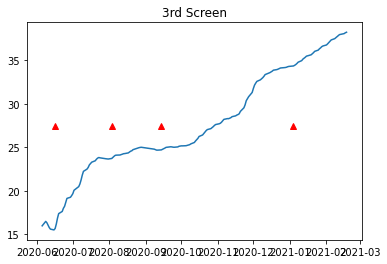

In [349]:
df['EMA130']=df['Close'].ewm(span=130).mean()
plt.plot(df.index,df['EMA130'],label='EMA130')
for i in range(len(df)-1):
  if df.EMA130.values[i]<df.EMA130.values[i+1] and df['%D'].values[i]<=20 and df['%D'].values[i+1]>20:
    plt.plot(df.index[i+1],df.EMA130.mean(),'r^') 
    buy.append(df.index.values[i])
  elif df.EMA130.values[i]>=df.EMA130.values[i+1] and df['%D'].values[i]>=80 and df['%D'].values[i+1]<80: 
    plt.plot(df.index[i+1],df.EMA130.mean(),'bv')
    sell.append(df.index.values[i])
plt.title('3rd Screen')

###• 종합

In [350]:
print(f'{stocks[0]} 매수시점:',buy) #매번 format함수만 써오다가 처음으로 fstring 포맷팅입문
print(f'{stocks[0]} 매도시점:',sell)

DADA 매수시점: [datetime.date(2020, 6, 25), datetime.date(2020, 6, 26), datetime.date(2020, 8, 24), datetime.date(2020, 10, 9), datetime.date(2020, 10, 12), datetime.date(2020, 10, 13), datetime.date(2020, 10, 14), datetime.date(2020, 10, 15), datetime.date(2020, 10, 16), datetime.date(2020, 10, 19), datetime.date(2021, 1, 12), datetime.date(2021, 1, 19), datetime.date(2020, 6, 15), datetime.date(2020, 7, 31), datetime.date(2020, 9, 11), datetime.date(2020, 12, 31)]
DADA 매도시점: []


##2)종목2

###• 볼린저 밴드

In [351]:
df=df2[['Open','High','Low','Close','Volume']]
df=df.iloc[-251:-1]
df['MA20']=df['Close'].rolling(window=20,min_periods=1).mean()
std=df['Close'].rolling(window=20,min_periods=1).std() 
std.fillna(method='bfill',inplace=True) 
df['Upper']=df['MA20']+2*std
df['Lower']=df['MA20']-2*std
df['%B']=100*(df.Close-df.Lower)/(df.Upper-df.Lower)
df['TP']=(df['High']+df['Lower']+df['Close'])/3 
df['PMF']=0
df['NMF']=0
for i in range(len(df)-1): 
  if df.TP.values[i]<df.TP.values[i+1]: 
    df.PMF.values[i+1]=df.TP.values[i+1]*df.Volume.values[i+1] 
    df.NMF.values[i+1]=0
  elif df.TP.values[i]>df.TP.values[i+1]:
    df.NMF.values[i+1]=df.TP.values[i+1]*df.Volume.values[i+1] 
    df.PMF.values[i+1]=0
MF=df.PMF.rolling(window=10).sum()/df.NMF.rolling(window=10).sum()
df['MFI']=100-100/(1+MF)

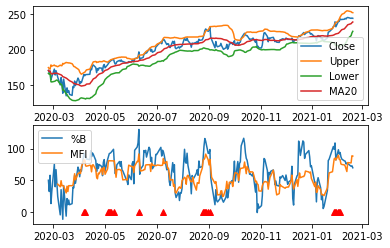

In [352]:
plt.subplot(2,1,1)
plt.plot(df.index,df.Close,label='Close')
plt.plot(df.index,df.Upper,label='Upper')
plt.plot(df.index,df.Lower,label='Lower')
plt.plot(df.index,df.MA20,label='MA20')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(df.index,df['%B'],label='%B')
plt.plot(df.index,df.MFI,label='MFI')
buy=[]
sell=[]
df.index=df.index.date 
for i in range(len(df)):
  if df['%B'].values[i]>80 and df.MFI.values[i]>80:
    plt.plot(df.index.values[i],0,'r^')
    buy.append(df.index.values[i])
  if df['%B'].values[i]<20 and df.MFI.values[i]<20:
    plt.plot(df.index.values[i],0,'bv')
    sell.append(df.index.values[i])
plt.legend(loc='best')

<BarContainer object of 250 artists>

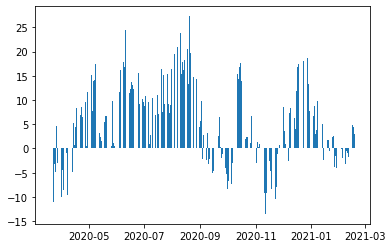

In [353]:
intensity=df.Volume*(2*df.Close-df.High-df.Low)/(df.High-df.Low) 
df['%I']=100*intensity.rolling(window=20).sum()/df.Volume.rolling(window=20).sum()
plt.bar(df.index,df['%I'],label='%I in 20days')

###• 삼중창

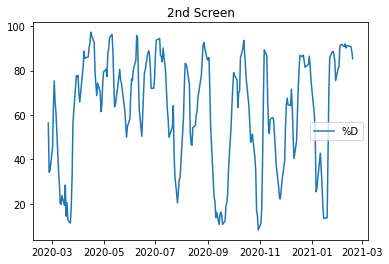

In [354]:
L14=df.Low.rolling(window=14,min_periods=1).min() 
H14=df.High.rolling(window=14,min_periods=1).max()
df['%K']=100*(df['Close']-L14)/(H14-L14)
df['%D']=df['%K'].rolling(window=3).mean() 
plt.plot(df.index,df['%D'],label='%D')
plt.title('2nd Screen')
plt.legend(loc='best')

Text(0.5, 1.0, '3rd Screen')

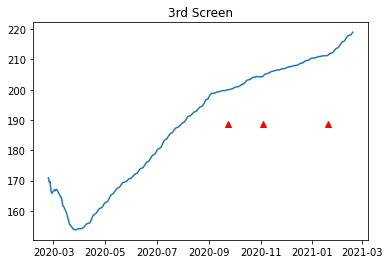

In [355]:
df['EMA130']=df['Close'].ewm(span=130).mean()
plt.plot(df.index,df['EMA130'],label='EMA130')
for i in range(len(df)-1):
  if df.EMA130.values[i]<df.EMA130.values[i+1] and df['%D'].values[i]<=20 and df['%D'].values[i+1]>20:
    plt.plot(df.index[i+1],df.EMA130.mean(),'r^') 
    buy.append(df.index.values[i])
  elif df.EMA130.values[i]>=df.EMA130.values[i+1] and df['%D'].values[i]>=80 and df['%D'].values[i+1]<80: 
    plt.plot(df.index[i+1],df.EMA130.mean(),'bv')
    sell.append(df.index.values[i])
plt.title('3rd Screen')

###• 종합

In [356]:
print(f'{stocks[1]} 매수시점:',buy)
print(f'{stocks[1]} 매도시점:',sell)

MSFT 매수시점: [datetime.date(2020, 4, 6), datetime.date(2020, 4, 7), datetime.date(2020, 5, 5), datetime.date(2020, 5, 6), datetime.date(2020, 5, 7), datetime.date(2020, 5, 8), datetime.date(2020, 5, 11), datetime.date(2020, 6, 10), datetime.date(2020, 7, 9), datetime.date(2020, 8, 25), datetime.date(2020, 8, 26), datetime.date(2020, 8, 27), datetime.date(2020, 8, 28), datetime.date(2020, 8, 31), datetime.date(2020, 9, 2), datetime.date(2021, 1, 27), datetime.date(2021, 1, 28), datetime.date(2021, 1, 29), datetime.date(2021, 2, 1), datetime.date(2021, 2, 2), datetime.date(2021, 2, 3), datetime.date(2020, 9, 22), datetime.date(2020, 11, 3), datetime.date(2021, 1, 19)]
MSFT 매도시점: []


##3)종목3

###• 볼린저 밴드

In [357]:
df=df3[['Open','High','Low','Close','Volume']]
df=df.iloc[-251:-1]
df['MA20']=df['Close'].rolling(window=20,min_periods=1).mean()
std=df['Close'].rolling(window=20,min_periods=1).std() 
std.fillna(method='bfill',inplace=True) 
df['Upper']=df['MA20']+2*std
df['Lower']=df['MA20']-2*std
df['%B']=100*(df.Close-df.Lower)/(df.Upper-df.Lower)
df['TP']=(df['High']+df['Lower']+df['Close'])/3 
df['PMF']=0
df['NMF']=0
for i in range(len(df)-1): 
  if df.TP.values[i]<df.TP.values[i+1]: 
    df.PMF.values[i+1]=df.TP.values[i+1]*df.Volume.values[i+1] 
    df.NMF.values[i+1]=0
  elif df.TP.values[i]>df.TP.values[i+1]:
    df.NMF.values[i+1]=df.TP.values[i+1]*df.Volume.values[i+1] 
    df.PMF.values[i+1]=0
MF=df.PMF.rolling(window=10).sum()/df.NMF.rolling(window=10).sum()
df['MFI']=100-100/(1+MF)

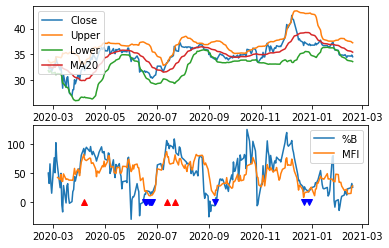

In [358]:
plt.subplot(2,1,1)
plt.plot(df.index,df.Close,label='Close')
plt.plot(df.index,df.Upper,label='Upper')
plt.plot(df.index,df.Lower,label='Lower')
plt.plot(df.index,df.MA20,label='MA20')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(df.index,df['%B'],label='%B')
plt.plot(df.index,df.MFI,label='MFI')
buy=[]
sell=[]
df.index=df.index.date 
for i in range(len(df)):
  if df['%B'].values[i]>80 and df.MFI.values[i]>80:
    plt.plot(df.index.values[i],0,'r^')
    buy.append(df.index.values[i])
  if df['%B'].values[i]<20 and df.MFI.values[i]<20:
    plt.plot(df.index.values[i],0,'bv')
    sell.append(df.index.values[i])
plt.legend(loc='best')

<BarContainer object of 250 artists>

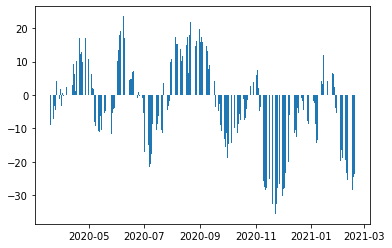

In [359]:
intensity=df.Volume*(2*df.Close-df.High-df.Low)/(df.High-df.Low) 
df['%I']=100*intensity.rolling(window=20).sum()/df.Volume.rolling(window=20).sum()
plt.bar(df.index,df['%I'],label='%I in 20days')

###• 삼중창

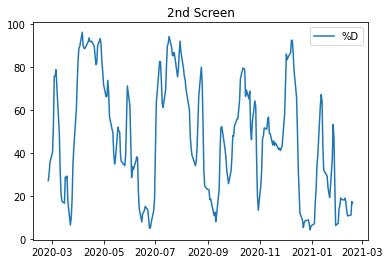

In [360]:
L14=df.Low.rolling(window=14,min_periods=1).min() 
H14=df.High.rolling(window=14,min_periods=1).max()
df['%K']=100*(df['Close']-L14)/(H14-L14)
df['%D']=df['%K'].rolling(window=3).mean() 
plt.plot(df.index,df['%D'],label='%D')
plt.title('2nd Screen')
plt.legend(loc='best')

Text(0.5, 1.0, '3rd Screen')

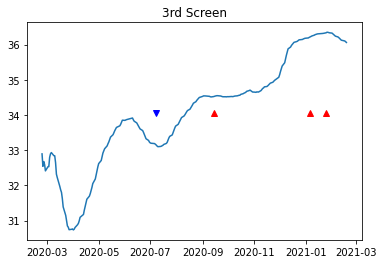

In [361]:
df['EMA130']=df['Close'].ewm(span=130).mean()
plt.plot(df.index,df['EMA130'],label='EMA130')
for i in range(len(df)-1):
  if df.EMA130.values[i]<df.EMA130.values[i+1] and df['%D'].values[i]<=20 and df['%D'].values[i+1]>20:
    plt.plot(df.index[i+1],df.EMA130.mean(),'r^') 
    buy.append(df.index.values[i])
  elif df.EMA130.values[i]>=df.EMA130.values[i+1] and df['%D'].values[i]>=80 and df['%D'].values[i+1]<80: 
    plt.plot(df.index[i+1],df.EMA130.mean(),'bv')
    sell.append(df.index.values[i])
plt.title('3rd Screen')

###• 종합

In [362]:
print(f'{stocks[2]} 매수시점:',buy)
print(f'{stocks[2]} 매도시점:',sell)

PFE 매수시점: [datetime.date(2020, 4, 6), datetime.date(2020, 7, 13), datetime.date(2020, 7, 23), datetime.date(2020, 9, 11), datetime.date(2021, 1, 5), datetime.date(2021, 1, 22)]
PFE 매도시점: [datetime.date(2020, 6, 17), datetime.date(2020, 6, 18), datetime.date(2020, 6, 19), datetime.date(2020, 6, 22), datetime.date(2020, 6, 23), datetime.date(2020, 6, 24), datetime.date(2020, 6, 25), datetime.date(2020, 6, 26), datetime.date(2020, 9, 8), datetime.date(2020, 12, 22), datetime.date(2020, 12, 28), datetime.date(2020, 7, 7)]


#4.예측


##1)종목1

In [363]:
from sklearn.preprocessing import MinMaxScaler
scaled_df=MinMaxScaler().fit_transform(df1) 
scaled_df=pd.DataFrame(scaled_df,columns=['Open','High','Low','Close','Adj Close','Volume']) #리스트에서 칼럼일부만 지정하긴 힘들다
scaled_df.drop('Adj Close',axis=1,inplace=True)
target_df=scaled_df['Close'] 

In [364]:
x=scaled_df.values.tolist() 
y=target_df.values.tolist()
xdata=[]
ydata=[]
window=10 
for i in range(len(y)-window):
  x_=x[i:i+window] 
  y_=y[i+window] 
  xdata.append(x_)
  ydata.append(y_)
print(x_,"->",y_)

[[0.8142857207732945, 0.6974225428282803, 0.7608142175024808, 0.7106481532582857, 0.16180107090587495], [0.7761904717516055, 0.6807450367314365, 0.7600508898072311, 0.733564770070451, 0.09042625940547548], [0.8172932127573513, 0.7667316343953496, 0.7948090901806542, 0.7317129641689554, 0.28525892637294553], [0.7862155725070565, 0.6757634568774997, 0.747073736591473, 0.6925925379754431, 0.17522965418915648], [0.7581453286343722, 0.6583712630766678, 0.7128498850179419, 0.6900463158987836, 0.18048997070417433], [0.7561403658471497, 0.6898418957946495, 0.7587785475603677, 0.6986111058374492, 0.1422847055883593], [0.7508772309734388, 0.6534546247875095, 0.7498727342288358, 0.6900463158987836, 0.03265734522818957], [0.7791979637356623, 0.6909248335676175, 0.7623409699590658, 0.7043981427722835, 0.10288552593767505], [0.7604009715240263, 0.6692657476168367, 0.7269719327104893, 0.6754629580981121, 0.10024945721217172], [0.7065163178812044, 0.6181502915533374, 0.6496183191658103, 0.624537015410

In [365]:
test_size=int(len(ydata)*0.3) 
X_train=np.array(xdata[0:len(xdata)-test_size+1])
X_test=np.array(xdata[len(xdata)-test_size:len(xdata)])
y_train=np.array(ydata[0:len(ydata)-test_size+1])
y_test=np.array(ydata[len(ydata)-test_size:len(ydata)])

In [366]:
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM,Dropout,Dense
model1=Sequential()
model1.add(LSTM(units=10,activation='relu',input_shape=(window,5),return_sequences=True)) 
model1.add(Dropout(0.1))
model1.add(LSTM(units=10,activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(units=1))
model1.summary() 

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 10, 10)            640       
_________________________________________________________________
dropout_34 (Dropout)         (None, 10, 10)            0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 10)                840       
_________________________________________________________________
dropout_35 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 1,491
Trainable params: 1,491
Non-trainable params: 0
_________________________________________________________________


In [367]:
model1.compile(optimizer='adam',loss='mean_squared_error') 
model1.fit(X_train,y_train,epochs=60,batch_size=30) 
pred=model1.predict(X_test)

Epoch 1/60
4/4 [==============================] - 1s 7ms/step - loss: 0.1849
Epoch 2/60
4/4 [==============================] - 0s 6ms/step - loss: 0.1650
Epoch 3/60
4/4 [==============================] - 0s 6ms/step - loss: 0.1366
Epoch 4/60
4/4 [==============================] - 0s 6ms/step - loss: 0.1217
Epoch 5/60
4/4 [==============================] - 0s 6ms/step - loss: 0.1132
Epoch 6/60
4/4 [==============================] - 0s 5ms/step - loss: 0.0941
Epoch 7/60
4/4 [==============================] - 0s 6ms/step - loss: 0.0724
Epoch 8/60
4/4 [==============================] - 0s 6ms/step - loss: 0.0743
Epoch 9/60
4/4 [==============================] - 0s 7ms/step - loss: 0.0381
Epoch 10/60
4/4 [==============================] - 0s 9ms/step - loss: 0.0427
Epoch 11/60
4/4 [==============================] - 0s 5ms/step - loss: 0.0366
Epoch 12/60
4/4 [==============================] - 0s 5ms/step - loss: 0.0187
Epoch 13/60
4/4 [==============================] - 0s 5ms/step - loss: 0.

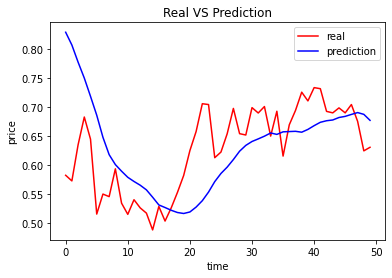

In [368]:
plt.plot(y_test,color='red',label='real')
plt.plot(pred,color='blue',label='prediction')
plt.title('Real VS Prediction')
plt.xlabel('time')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()

In [369]:
price=pred[-1]*df.Close.iloc[-1]/scaled_df.Close.iloc[-1]
print(f"내일 {stocks[0]} 주가는 ${price}") 

내일 DADA 주가는 $[37.105305]


##2)종목2

In [370]:
from sklearn.preprocessing import MinMaxScaler
df2=df2.iloc[-251:-1]
scaled_df=MinMaxScaler().fit_transform(df2) 
scaled_df=pd.DataFrame(scaled_df,columns=['Open','High','Low','Close','Adj Close','Volume']) 
scaled_df.drop('Adj Close',axis=1,inplace=True)
target_df=scaled_df['Close'] 
x=scaled_df.values.tolist() 
y=target_df.values.tolist()
xdata=[]
ydata=[]
window=10 
for i in range(len(y)-window):
  x_=x[i:i+window] 
  y_=y[i+window] 
  xdata.append(x_)
  ydata.append(y_)
test_size=int(len(ydata)*0.3) 
X_train=np.array(xdata[0:len(xdata)-test_size+1])
X_test=np.array(xdata[len(xdata)-test_size:len(xdata)])
y_train=np.array(ydata[0:len(ydata)-test_size+1])
y_test=np.array(ydata[len(ydata)-test_size:len(ydata)])
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM,Dropout,Dense
model2=Sequential()
model2.add(LSTM(units=10,activation='relu',input_shape=(window,5),return_sequences=True)) 
model2.add(Dropout(0.1))
model2.add(LSTM(units=10,activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(units=1))
model2.compile(optimizer='adam',loss='mean_squared_error') 
model2.fit(X_train,y_train,epochs=60,batch_size=30) 
pred=model2.predict(X_test)

Epoch 1/60
6/6 [==============================] - 2s 8ms/step - loss: 0.3102
Epoch 2/60
6/6 [==============================] - 0s 7ms/step - loss: 0.2892
Epoch 3/60
6/6 [==============================] - 0s 7ms/step - loss: 0.2650
Epoch 4/60
6/6 [==============================] - 0s 7ms/step - loss: 0.2513
Epoch 5/60
6/6 [==============================] - 0s 7ms/step - loss: 0.2226
Epoch 6/60
6/6 [==============================] - 0s 8ms/step - loss: 0.1848
Epoch 7/60
6/6 [==============================] - 0s 7ms/step - loss: 0.1353
Epoch 8/60
6/6 [==============================] - 0s 9ms/step - loss: 0.0697
Epoch 9/60
6/6 [==============================] - 0s 7ms/step - loss: 0.0317
Epoch 10/60
6/6 [==============================] - 0s 8ms/step - loss: 0.0476
Epoch 11/60
6/6 [==============================] - 0s 7ms/step - loss: 0.0289
Epoch 12/60
6/6 [==============================] - 0s 7ms/step - loss: 0.0294
Epoch 13/60
6/6 [==============================] - 0s 7ms/step - loss: 0.

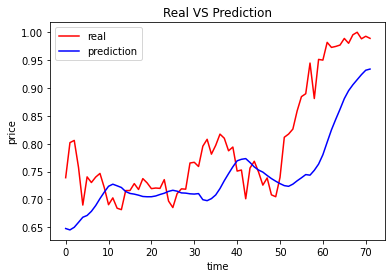

In [371]:
plt.plot(y_test,color='red',label='real')
plt.plot(pred,color='blue',label='prediction')
plt.title('Real VS Prediction')
plt.xlabel('time')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()

In [372]:
price=pred[-1]*df.Close.iloc[-1]/scaled_df.Close.iloc[-1]
print(f"내일 {stocks[1]} 주가는 ${price}") 

내일 MSFT 주가는 $[32.634422]


##3)종목3

In [373]:
from sklearn.preprocessing import MinMaxScaler
df3=df3.iloc[-251:-1]
scaled_df=MinMaxScaler().fit_transform(df3) 
scaled_df=pd.DataFrame(scaled_df,columns=['Open','High','Low','Close','Adj Close','Volume']) 
scaled_df.drop('Adj Close',axis=1,inplace=True)
target_df=scaled_df['Close'] 
x=scaled_df.values.tolist() 
y=target_df.values.tolist()
xdata=[]
ydata=[]
window=10 
for i in range(len(y)-window):
  x_=x[i:i+window] 
  y_=y[i+window] 
  xdata.append(x_)
  ydata.append(y_)
test_size=int(len(ydata)*0.3) 
X_train=np.array(xdata[0:len(xdata)-test_size+1])
X_test=np.array(xdata[len(xdata)-test_size:len(xdata)])
y_train=np.array(ydata[0:len(ydata)-test_size+1])
y_test=np.array(ydata[len(ydata)-test_size:len(ydata)])
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM,Dropout,Dense
model3=Sequential()
model3.add(LSTM(units=10,activation='relu',input_shape=(window,5),return_sequences=True)) 
model3.add(Dropout(0.1))
model3.add(LSTM(units=10,activation='relu'))
model3.add(Dropout(0.1))
model3.add(Dense(units=1))
model3.compile(optimizer='adam',loss='mean_squared_error') 
model3.fit(X_train,y_train,epochs=60,batch_size=30) 
pred=model3.predict(X_test)

Epoch 1/60
6/6 [==============================] - 2s 7ms/step - loss: 0.2245
Epoch 2/60
6/6 [==============================] - 0s 7ms/step - loss: 0.1772
Epoch 3/60
6/6 [==============================] - 0s 7ms/step - loss: 0.1313
Epoch 4/60
6/6 [==============================] - 0s 8ms/step - loss: 0.0958
Epoch 5/60
6/6 [==============================] - 0s 8ms/step - loss: 0.0673
Epoch 6/60
6/6 [==============================] - 0s 9ms/step - loss: 0.0417
Epoch 7/60
6/6 [==============================] - 0s 8ms/step - loss: 0.0197
Epoch 8/60
6/6 [==============================] - 0s 8ms/step - loss: 0.0199
Epoch 9/60
6/6 [==============================] - 0s 7ms/step - loss: 0.0217
Epoch 10/60
6/6 [==============================] - 0s 7ms/step - loss: 0.0238
Epoch 11/60
6/6 [==============================] - 0s 8ms/step - loss: 0.0177
Epoch 12/60
6/6 [==============================] - 0s 8ms/step - loss: 0.0167
Epoch 13/60
6/6 [==============================] - 0s 7ms/step - loss: 0.

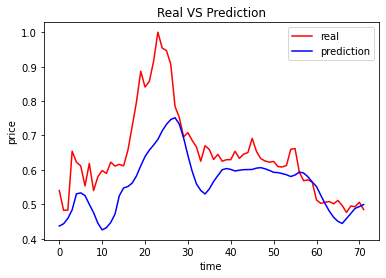

In [374]:
plt.plot(y_test,color='red',label='real')
plt.plot(pred,color='blue',label='prediction')
plt.title('Real VS Prediction')
plt.xlabel('time')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()

In [375]:
price=pred[-1]*df.Close.iloc[-1]/scaled_df.Close.iloc[-1]
print(f"내일 {stocks[2]} 주가는 ${price}") 

내일 PFE 주가는 $[35.59739]


#5.결론